Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
% cd '/content/drive/My Drive/Colab Notebooks/c247'

from all_models import *
from all_solvers import *
from all_functions import *

import numpy as np
%matplotlib inline
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from sklearn.model_selection import KFold
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
device = torch.device('cuda' if torch.cuda.is_available() else'cpu')

/content/drive/My Drive/Colab Notebooks/c247


Load Data

In [ ]:
# subject data
subject = 2
X_test, y_test, X_train_valid, y_train_valid = import_data_subject(subject)


# DeepConv, trialsize 900, stride 10

-- Fold [1/5] --
Epoch [10], Training loss [1.2607], Training accuracy [41.05%]
Epoch [10], Validation loss [1.2919], Validation accuracy [39.77%]
Epoch [20], Training loss [1.1485], Training accuracy [47.97%]
Epoch [20], Validation loss [1.2658], Validation accuracy [42.61%]
Epoch [30], Training loss [1.0102], Training accuracy [57.40%]
Epoch [30], Validation loss [1.2021], Validation accuracy [45.83%]
Epoch [40], Training loss [0.9011], Training accuracy [61.65%]
Epoch [40], Validation loss [1.1791], Validation accuracy [49.05%]
Epoch [50], Training loss [0.7903], Training accuracy [68.13%]
Epoch [50], Validation loss [1.1913], Validation accuracy [51.70%]
Epoch [60], Training loss [0.7254], Training accuracy [71.71%]
Epoch [60], Validation loss [1.1919], Validation accuracy [51.33%]
Epoch [70], Training loss [0.6288], Training accuracy [75.92%]
Epoch [70], Validation loss [1.1279], Validation accuracy [52.84%]
Epoch [80], Training loss [0.5623], Training accuracy [78.48%]
Epoch [80]

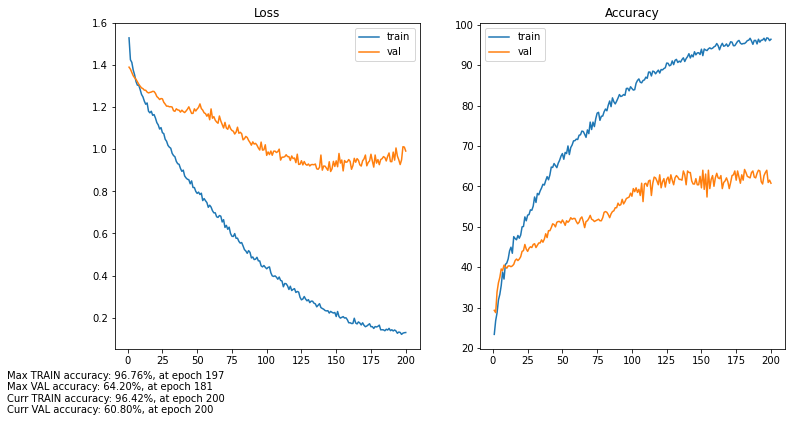

In [ ]:
# Set up cross validation folds, and average accuracy tracker
kf = KFold(n_splits=5, random_state=None, shuffle=True)
avg_accuracy=0
kcount = 1

for k_train_index, k_val_index in kf.split(X_train_valid):
  ## Only compute 1 fold due to computation time:
  if kcount==2:
    break
  ## Print fold
  print('-- Fold [{}/5] --'.format(kcount))

  ## Create this fold's dataloader
  SEGMENT = True
  VOTE = False
  window_width = 900
  stride = 10
  num_slices = int((1000-window_width)/stride+1)

  dataloaders = make_dataloaders(k_train_index, k_val_index, X_train_valid, y_train_valid, X_test, y_test, 
                                 cut=SEGMENT, window_width=window_width, stride=stride, num_slices=num_slices)
  
  ## Create model, hyperpatameters, optimizer, loss function 
  weight_decay = 0.001
  model = DeepConv(in_channels=1, classes=4, cnn_drop=0.5, trial_length=window_width).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay=weight_decay)
  loss_fn = nn.CrossEntropyLoss()
  num_epochs = 200

  ## Start training/validating/training
  # set up per epoch accuracy and loss trackers
  loss_tracker = {'train':[], 'val':[]}
  accuracy_tracker = {'train':[], 'val':[]}
  best_model_params = [0, model]

  for epoch in range(num_epochs): 
    logs = {}
    # train on training samples
    model, epoch_loss_avg, epoch_accuracy = train(model, optimizer, loss_fn, dataloaders, device, epoch)
    loss_tracker['train'].append(epoch_loss_avg)
    accuracy_tracker['train'].append(epoch_accuracy)

    # evalutate on validation samples 
    epoch_loss_avg, epoch_accuracy, best_model_params = validate(model, optimizer, loss_fn, dataloaders, device, epoch, best_model_params)
    loss_tracker['val'].append(epoch_loss_avg)
    accuracy_tracker['val'].append(epoch_accuracy)

  # plot train/validation graph
  make_plot(num_epochs, loss_tracker, accuracy_tracker, saveplot=False)
  # get model weights from the epoch with the highest validation accuracy
  _, final_best_model = best_model_params
  thisacc = finaltest(final_best_model, dataloaders, device)
  print('Test accuracy from the best model during fold [{}] is: [{:.2f}%]'.format(kcount, thisacc))
  kcount += 1
  avg_accuracy += thisacc

print('Average test accuracy of 5-fold validation: [{:.2f}]'.format(avg_accuracy/5))

# DeepConv2, trialsize 900, stride 10

-- Fold [1/5] --
Epoch [10], Training loss [1.3829], Training accuracy [27.61%]
Epoch [10], Validation loss [1.3805], Validation accuracy [31.63%]
Epoch [20], Training loss [1.3552], Training accuracy [35.30%]
Epoch [20], Validation loss [1.3792], Validation accuracy [29.55%]
Epoch [30], Training loss [1.2189], Training accuracy [46.42%]
Epoch [30], Validation loss [1.4333], Validation accuracy [29.17%]
Epoch [40], Training loss [1.0464], Training accuracy [53.14%]
Epoch [40], Validation loss [1.6152], Validation accuracy [29.17%]
Epoch [50], Training loss [0.8986], Training accuracy [62.86%]
Epoch [50], Validation loss [1.8512], Validation accuracy [29.17%]
Epoch [60], Training loss [0.7637], Training accuracy [70.07%]
Epoch [60], Validation loss [2.0103], Validation accuracy [29.17%]
Epoch [70], Training loss [0.6579], Training accuracy [75.05%]
Epoch [70], Validation loss [2.1428], Validation accuracy [29.17%]
Epoch [80], Training loss [0.5845], Training accuracy [79.64%]
Epoch [80]

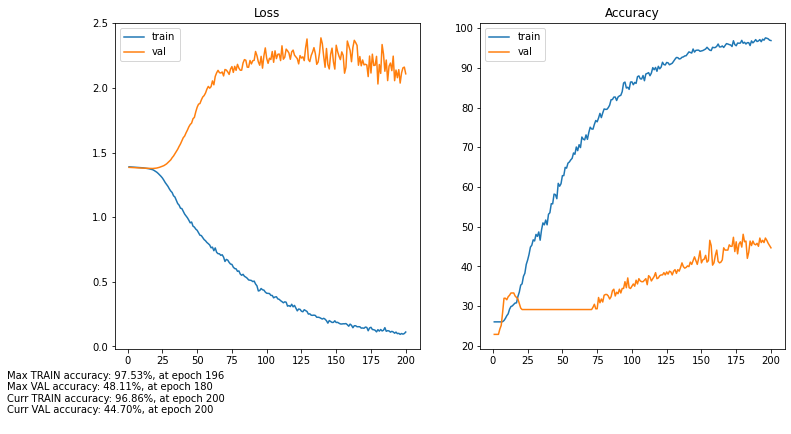

In [ ]:
# Set up cross validation folds, and average accuracy tracker
kf = KFold(n_splits=5, random_state=None, shuffle=True)
avg_accuracy=0
kcount = 1

for k_train_index, k_val_index in kf.split(X_train_valid):
  ## Only compute 1 fold due to computation time:
  if kcount==2:
    break
  ## Print fold
  print('-- Fold [{}/5] --'.format(kcount))

  ## Create this fold's dataloader
  SEGMENT = True
  VOTE = False
  window_width = 900
  stride = 10
  num_slices = int((1000-window_width)/stride+1)

  dataloaders = make_dataloaders(k_train_index, k_val_index, X_train_valid, y_train_valid, X_test, y_test, 
                                 cut=SEGMENT, window_width=window_width, stride=stride, num_slices=num_slices)
  
  ## Create model, hyperpatameters, optimizer, loss function 
  weight_decay = 0.001
  model = DeepConv2(in_channels=1, classes=4, cnn_drop=0.5).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay=weight_decay)
  loss_fn = nn.CrossEntropyLoss()
  num_epochs = 200

  ## Start training/validating/training
  # set up per epoch accuracy and loss trackers
  loss_tracker = {'train':[], 'val':[]}
  accuracy_tracker = {'train':[], 'val':[]}
  best_model_params = [0, model]

  for epoch in range(num_epochs): 
    logs = {}
    # train on training samples
    model, epoch_loss_avg, epoch_accuracy = train(model, optimizer, loss_fn, dataloaders, device, epoch)
    loss_tracker['train'].append(epoch_loss_avg)
    accuracy_tracker['train'].append(epoch_accuracy)

    # evalutate on validation samples 
    epoch_loss_avg, epoch_accuracy, best_model_params = validate(model, optimizer, loss_fn, dataloaders, device, epoch, best_model_params)
    loss_tracker['val'].append(epoch_loss_avg)
    accuracy_tracker['val'].append(epoch_accuracy)

  # plot train/validation graph
  make_plot(num_epochs, loss_tracker, accuracy_tracker, saveplot=False)
  # get model weights from the epoch with the highest validation accuracy
  _, final_best_model = best_model_params
  thisacc = finaltest(final_best_model, dataloaders, device)
  print('Test accuracy from the best model during fold [{}] is: [{:.2f}%]'.format(kcount, thisacc))
  kcount += 1
  avg_accuracy += thisacc

print('Average test accuracy of 5-fold validation: [{:.2f}]'.format(avg_accuracy/5))

# Conv1, trialsize 900, stride 10

-- Fold [1/5] --
Epoch [10], Training loss [1.3110], Training accuracy [36.99%]
Epoch [10], Validation loss [1.3883], Validation accuracy [26.52%]
Epoch [20], Training loss [1.1902], Training accuracy [46.23%]
Epoch [20], Validation loss [1.3796], Validation accuracy [37.50%]
Epoch [30], Training loss [1.0593], Training accuracy [54.59%]
Epoch [30], Validation loss [1.3873], Validation accuracy [39.77%]
Epoch [40], Training loss [0.9251], Training accuracy [62.77%]
Epoch [40], Validation loss [1.4434], Validation accuracy [37.31%]
Epoch [50], Training loss [0.7815], Training accuracy [68.76%]
Epoch [50], Validation loss [1.4145], Validation accuracy [40.34%]
Epoch [60], Training loss [0.6145], Training accuracy [76.40%]
Epoch [60], Validation loss [1.3990], Validation accuracy [43.56%]
Epoch [70], Training loss [0.5084], Training accuracy [80.27%]
Epoch [70], Validation loss [1.4130], Validation accuracy [44.70%]
Epoch [80], Training loss [0.3962], Training accuracy [86.41%]
Epoch [80]

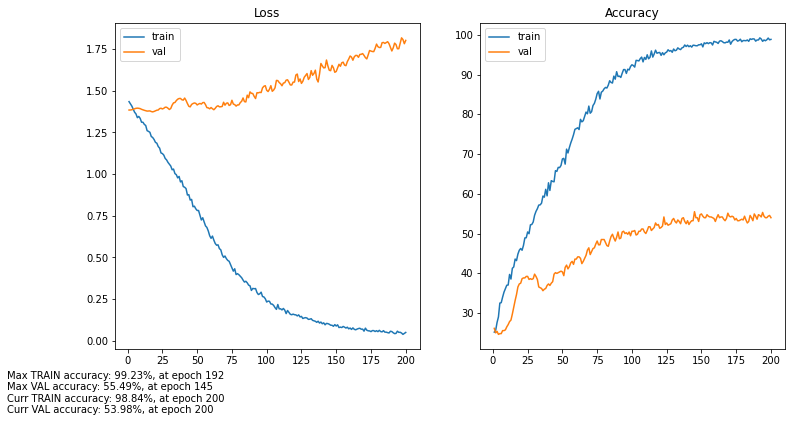

In [ ]:
# Set up cross validation folds, and average accuracy tracker
kf = KFold(n_splits=5, random_state=None, shuffle=True)
avg_accuracy=0
kcount = 1

for k_train_index, k_val_index in kf.split(X_train_valid):
  ## Only compute 1 fold due to computation time:
  if kcount==2:
    break
  ## Print fold
  print('-- Fold [{}/5] --'.format(kcount))

  ## Create this fold's dataloader
  SEGMENT = True
  VOTE = False
  window_width = 900
  stride = 10
  num_slices = int((1000-window_width)/stride+1)

  dataloaders = make_dataloaders(k_train_index, k_val_index, X_train_valid, y_train_valid, X_test, y_test, 
                                 cut=SEGMENT, window_width=window_width, stride=stride, num_slices=num_slices)
  
  ## Create model, hyperpatameters, optimizer, loss function 
  weight_decay = 0.001
  model = Conv1(dropout=0.5, trial_length=window_width).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay=weight_decay)
  loss_fn = nn.CrossEntropyLoss()
  num_epochs = 200

  ## Start training/validating/training
  # set up per epoch accuracy and loss trackers
  loss_tracker = {'train':[], 'val':[]}
  accuracy_tracker = {'train':[], 'val':[]}
  best_model_params = [0, model]

  for epoch in range(num_epochs): 
    logs = {}
    # train on training samples
    model, epoch_loss_avg, epoch_accuracy = train(model, optimizer, loss_fn, dataloaders, device, epoch)
    loss_tracker['train'].append(epoch_loss_avg)
    accuracy_tracker['train'].append(epoch_accuracy)

    # evalutate on validation samples 
    epoch_loss_avg, epoch_accuracy, best_model_params = validate(model, optimizer, loss_fn, dataloaders, device, epoch, best_model_params)
    loss_tracker['val'].append(epoch_loss_avg)
    accuracy_tracker['val'].append(epoch_accuracy)

  # plot train/validation graph
  make_plot(num_epochs, loss_tracker, accuracy_tracker, saveplot=False)
  # get model weights from the epoch with the highest validation accuracy
  _, final_best_model = best_model_params
  thisacc = finaltest(final_best_model, dataloaders, device)
  print('Test accuracy from the best model during fold [{}] is: [{:.2f}%]'.format(kcount, thisacc))
  kcount += 1
  avg_accuracy += thisacc

print('Average test accuracy of 5-fold validation: [{:.2f}]'.format(avg_accuracy/5))

# Conv2, trialsize 900, stride 10

-- Fold [1/5] --
Epoch [10], Training loss [1.3811], Training accuracy [27.18%]
Epoch [10], Validation loss [1.3773], Validation accuracy [28.98%]
Epoch [20], Training loss [1.3637], Training accuracy [34.57%]
Epoch [20], Validation loss [1.3574], Validation accuracy [37.50%]
Epoch [30], Training loss [1.2898], Training accuracy [41.78%]
Epoch [30], Validation loss [1.3041], Validation accuracy [40.91%]
Epoch [40], Training loss [1.1382], Training accuracy [50.97%]
Epoch [40], Validation loss [1.1462], Validation accuracy [47.92%]
Epoch [50], Training loss [0.9882], Training accuracy [61.70%]
Epoch [50], Validation loss [1.0328], Validation accuracy [52.08%]
Epoch [60], Training loss [0.8758], Training accuracy [65.28%]
Epoch [60], Validation loss [0.9905], Validation accuracy [55.11%]
Epoch [70], Training loss [0.8117], Training accuracy [67.50%]
Epoch [70], Validation loss [1.0235], Validation accuracy [54.73%]
Epoch [80], Training loss [0.7318], Training accuracy [70.74%]
Epoch [80]

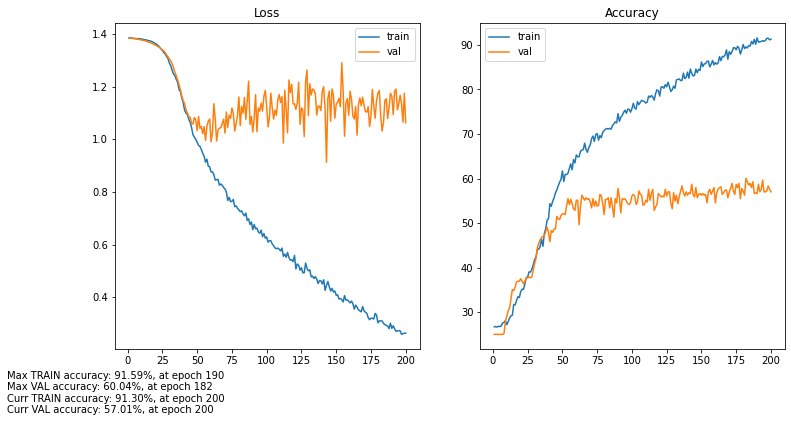

In [ ]:
# Set up cross validation folds, and average accuracy tracker
kf = KFold(n_splits=5, random_state=None, shuffle=True)
avg_accuracy=0
kcount = 1

for k_train_index, k_val_index in kf.split(X_train_valid):
  ## Only compute 1 fold due to computation time:
  if kcount==2:
    break
  ## Print fold
  print('-- Fold [{}/5] --'.format(kcount))

  ## Create this fold's dataloader
  SEGMENT = True
  VOTE = False
  window_width = 900
  stride = 10
  num_slices = int((1000-window_width)/stride+1)

  dataloaders = make_dataloaders(k_train_index, k_val_index, X_train_valid, y_train_valid, X_test, y_test, 
                                 cut=SEGMENT, window_width=window_width, stride=stride, num_slices=num_slices)
  
  ## Create model, hyperpatameters, optimizer, loss function 
  weight_decay = 0.001
  model = Conv2(dropout=0.5).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay=weight_decay)
  loss_fn = nn.CrossEntropyLoss()
  num_epochs = 200

  ## Start training/validating/training
  # set up per epoch accuracy and loss trackers
  loss_tracker = {'train':[], 'val':[]}
  accuracy_tracker = {'train':[], 'val':[]}
  best_model_params = [0, model]

  for epoch in range(num_epochs): 
    logs = {}
    # train on training samples
    model, epoch_loss_avg, epoch_accuracy = train(model, optimizer, loss_fn, dataloaders, device, epoch)
    loss_tracker['train'].append(epoch_loss_avg)
    accuracy_tracker['train'].append(epoch_accuracy)

    # evalutate on validation samples 
    epoch_loss_avg, epoch_accuracy, best_model_params = validate(model, optimizer, loss_fn, dataloaders, device, epoch, best_model_params)
    loss_tracker['val'].append(epoch_loss_avg)
    accuracy_tracker['val'].append(epoch_accuracy)

  # plot train/validation graph
  make_plot(num_epochs, loss_tracker, accuracy_tracker, saveplot=False)
  # get model weights from the epoch with the highest validation accuracy
  _, final_best_model = best_model_params
  thisacc = finaltest(final_best_model, dataloaders, device)
  print('Test accuracy from the best model during fold [{}] is: [{:.2f}%]'.format(kcount, thisacc))
  kcount += 1
  avg_accuracy += thisacc

print('Average test accuracy of 5-fold validation: [{:.2f}]'.format(avg_accuracy/5))